Autores: Alexandre Liermann, Gustavo Guerreiro e João Martinho.

# Implementação de Classificação de Imagens de Ressonância Magnética para Diagnóstico de Alzheimer Usando CNN em TensorFlow

Importações das bibliotecas necessárias

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
os.environ['TF_CUDNN_BENCHMARK'] = 'false'

import gc
import pathlib
import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt
from tensorflow.data import AUTOTUNE
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import models, layers, mixed_precision
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


Definindo constantes a serem usadas

In [2]:
IMG_ALTURA    = 176
IMG_LARGURA   = 208
TAMANHO_BATCH = 256

SEED = 2025

In [3]:
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.config.experimental.enable_op_determinism()

print('Seed global definida:', SEED)

Seed global definida: 2025


In [4]:
def configurar_gpu():
    try:
        gpus = tf.config.list_physical_devices('GPU')
        if gpus:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(f"Erro ao configurar GPU: {e}")

mixed_precision.set_global_policy('mixed_float16')
configurar_gpu()

Definindo os diretórios do dataset

In [5]:
dir_dados = pathlib.Path('dataset')
dataset_completo = tf.keras.utils.image_dataset_from_directory(
    dir_dados,
    seed=SEED,
    shuffle=True,
    image_size=(IMG_ALTURA, IMG_LARGURA),
    batch_size=None,
    color_mode='rgb'
)

def separar_dataset(ds, train_split=0.7, val_split=0.15):
    ds = ds.shuffle(10000, seed=SEED)

    ds_size = len(ds)

    train_size = int(train_split * ds_size)
    val_size   = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds   = ds.skip(train_size).take(val_size)
    test_ds  = ds.skip(train_size + val_size)

    return (
        train_ds,
        val_ds,
        test_ds
    )

dataset_treino, dataset_val, dataset_teste = separar_dataset(dataset_completo)

Found 6400 files belonging to 4 classes.


I0000 00:00:1763666246.101182   90092 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [6]:
def preparar_para_treino(ds, shuffle=False):
    if shuffle:
        ds = ds.shuffle(10000, seed=SEED, reshuffle_each_iteration=True)
    ds = ds.batch(TAMANHO_BATCH)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

dataset_treino = preparar_para_treino(dataset_treino, shuffle=True)
dataset_val = preparar_para_treino(dataset_val)
dataset_teste = preparar_para_treino(dataset_teste)

print("Datasets prontos!")
print(f"Batches de Treino: {len(dataset_treino)}")
print(f"Batches de Validação: {len(dataset_val)}")
print(f"Batches de Teste: {len(dataset_teste)}")

Datasets prontos!
Batches de Treino: 18
Batches de Validação: 4
Batches de Teste: 4


Iniciando a configuração do modelo.

In [7]:
tf.keras.backend.clear_session()
gc.collect()

modelo = models.Sequential([
    layers.Input(shape=(IMG_ALTURA, IMG_LARGURA, 3)),

    layers.Lambda(lambda x: tf.image.rgb_to_grayscale(x)),
    layers.Rescaling(1./255),

    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')
])

Compilando o modelo com a definição de otimizador (Adaptive Moment Estimation), perda e métricas.

In [8]:
modelo.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
    jit_compile=True
)

/home/guto/cats_dogs/aprendizado_de_maquina/venv/lib/python3.12/site-packages/keras/src/trainers/trainer.py:212: UserWarning: Model doesn't support `jit_compile=True`. Proceeding with `jit_compile=False`.
  warnings.warn(


Definindo callback de EarlyStopping.

In [9]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

Treinando o modelo

In [10]:
history = modelo.fit(
    dataset_treino,
    validation_data=dataset_val,
    epochs=50,
    callbacks=[early_stop]
)

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 386ms/step - accuracy: 0.4725 - loss: 1.3906 - val_accuracy: 0.5063 - val_loss: 1.0461
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 276ms/step - accuracy: 0.4967 - loss: 1.0332 - val_accuracy: 0.5135 - val_loss: 0.9932
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 281ms/step - accuracy: 0.5141 - loss: 1.0019 - val_accuracy: 0.5490 - val_loss: 0.9648
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 268ms/step - accuracy: 0.5545 - loss: 0.9345 - val_accuracy: 0.5938 - val_loss: 0.8859
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 280ms/step - accuracy: 0.5661 - loss: 0.9085 - val_accuracy: 0.6281 - val_loss: 0.8506
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 267ms/step - accuracy: 0.6042 - loss: 0.8551 - val_accuracy: 0.6656 - val_loss: 0.7512
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 302ms/step - accuracy: 0.6362 - loss: 0.7930 - val_accuracy: 0.6583 - val_loss: 0.7255
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 265ms/step - accuracy: 0.6839 - loss: 0.7141 - val_accuracy: 0

Métricas mais avançadas com sklearn

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Relatório de Classificação:

              precision    recall  f1-score   support

        Mild       1.00      1.00      1.00       145
         Mod       1.00      1.00      1.00         7
         Non       1.00      1.00      1.00       469
       VMild       1.00      1.00      1.00       339

    accuracy                           1.00       960
   macro avg       1.00      1.00      1.00       960
weighted avg       1.00      1.00      1.00       960



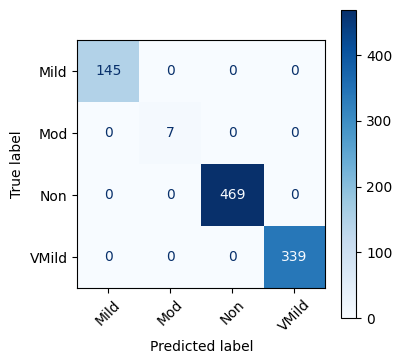

In [11]:
y_verdadeiro = []
y_previsto = []

for imagens, rotulos in dataset_teste:
    previsoes = modelo.predict(imagens)
    y_verdadeiro.extend(rotulos.numpy())
    y_previsto.extend(np.argmax(previsoes, axis=1))


classes = ['Mild', 'Mod', 'Non', 'VMild']

print("Relatório de Classificação:\n")
print(classification_report(y_verdadeiro, y_previsto, target_names=classes))

cm = confusion_matrix(y_verdadeiro, y_previsto)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

fig, ax = plt.subplots(figsize=(4, 4))
disp.plot(xticks_rotation=45, cmap='Blues', ax=ax)
plt.show()

In [12]:
ARQUIVO_MODELO = 'alzheimer_previsao.keras'

modelo.save(ARQUIVO_MODELO)